In [1]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: Estimation of parameters (harmonic sum)

In [2]:
# Estimate parameters and standard errors (random frequency)

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)
p1, s1 = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate parameters and errors (automatic)
p2, s2 = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate errors (average over noise realizations)
box = []
for _ in range(8192):
    y = x + s_x.reshape(-1, 1)*torch.randn_like(x, dtype=dtype, device=device)
    out, _ = Decomposition.harmonic_sum(0.12 + 1.0E-5*torch.randn(1, dtype=dtype, device=device), w.window, y)
    box.append(out)    
box = torch.stack(box).T.std(-1).T

# Compare parameters
print(p1)
print(p2)
print()

# Compare errors
print(s1)
print(s2)
print(box)
print()

tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)
tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)

tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.800599450917e-03, 8.495099644970e-03, 2.688768239363e-03, 3.413802724088e-02],
        [1.156953992634e-02, 2.116613627465e-02, 5.456384974039e-04, 

# Example-02: Estimation of parameters (harmonic sum & batched mode)

In [3]:
# Estimate parameters and errors for a batch of frequencies

# Set parameters
length = 1024
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 1.0, dtype=torch.float64, device='cpu')

# Set noise parameters
s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.60)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25), 0.25*torch.cos(2.0*numpy.pi*0.24*t + 0.15)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10), 0.01*torch.cos(2.0*numpy.pi*0.36*t + 0.50)])
x = x1 + x2 + x3

# Compute parameters and errors for each frequency (direct)
p1a, s1a = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1b, s1b = Decomposition.harmonic_sum(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1c, s1c = Decomposition.harmonic_sum(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1 = torch.stack([p1a, p1b, p1c])
s1 = torch.stack([s1a, s1b, s1c])

# Compute parameters and errors for each frequency (automatic)
p2a, s2a = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2b, s2b = Decomposition.harmonic_sum_automatic(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2c, s2c = Decomposition.harmonic_sum_automatic(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2 = torch.stack([p2a, p2b, p2c])
s2 = torch.stack([s2a, s2b, s2c])

# Compute parameters and errors for each frequency (batched)
p3, s3 = Decomposition.harmonic_sum_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=dtype, device=device),
    w.window,
    x,
    error=True,
    sigma=s_x,
    sigma_frequency=torch.tensor([s_f, s_f, s_f], dtype=dtype, device=device))

# Compare errors
print(s1)
print(s2)
print(s3)

tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.706329386826e-03, 6.296499040365e-02],
         [5.628105253876e-04, 6.104693260486e-04, 5.412658773675e-04, 6.296490438044e-02]]],
       dtype=torch.float64)
tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.

In [4]:
# Estimate parameters for a list of harmonics

# Set parameters
length = 2048
dtype = torch.float64
device = 'cpu'

# Set window
w = Window.from_cosine(length, 4.0, dtype=torch.float64, device='cpu')

# Set data
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10)])
x = x1 + x2 + x3

# Set harmonics
f = 0.12
h = torch.tensor([*Frequency.harmonics(10, [f]).values()], dtype=dtype, device=device)

# Estimate parameters
param, _ = Decomposition.harmonic_sum_batched(h, w.window, x, error=False)

# Result (amplitude)
*_, a, _ = param.T
print(a.T)

tensor([[2.500000000000e-01],
        [1.000000000000e-01],
        [5.000000000000e-02],
        [2.623619031558e-16],
        [4.015512494878e-16],
        [3.147267753522e-16],
        [1.854150954133e-16],
        [1.135456674832e-16],
        [7.519772959361e-16],
        [2.807503616015e-16]], dtype=torch.float64)


# Example-03: Estimator bias

w1: 2.09465512e-05 2.2936407e-06
w2: 3.7373038e-09 4.98039843e-09


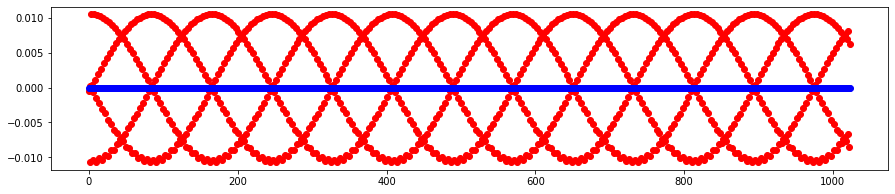

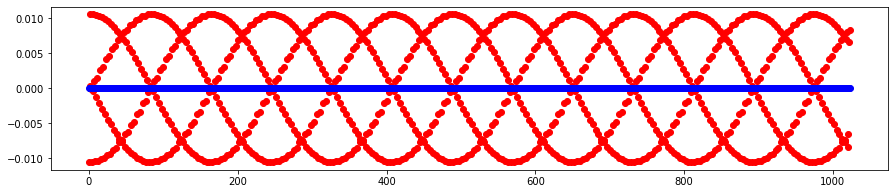

In [5]:
# Given a noise-free signal containing several components
# Parameters for a given frequency can be estimated using (weighted) harmonic sum
# Estimated values depend on the length used for estimation and as well as on the signal starting position
# In this example, estimator bias is explored
# Ensembling several estimators (fixed length and different starting position) in general will improve estimation accuracy (reduce bias)

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 1.0, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Change window order, sample length and/or number of samples to observe convergents
limit = 1024
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    
    y = x[:, step*shift: step*shift + 128]
    
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)
    
# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

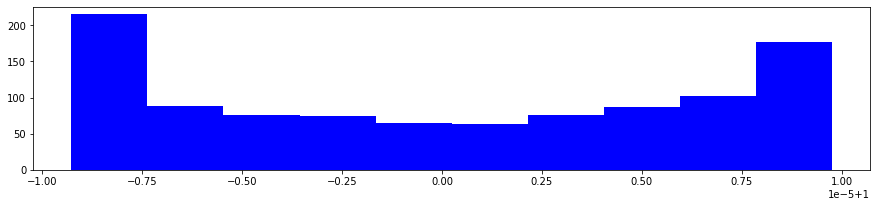

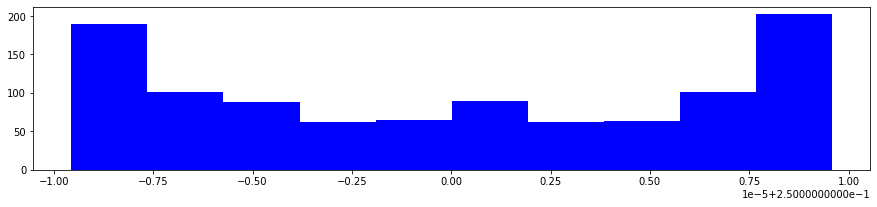

In [6]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution is not normal (not random)
# It is not symmetric if signal containes more than one component

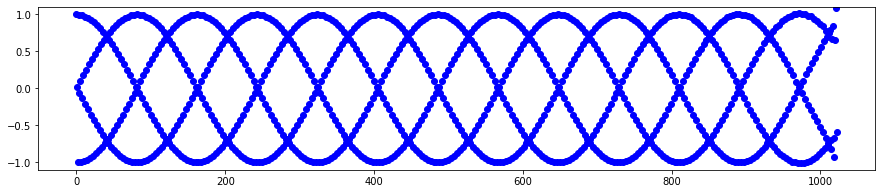

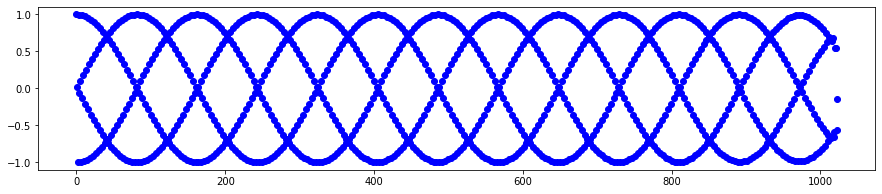

In [7]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

w1: 3.38341009e-06 1.94870729e-05
w2: 2.06613804e-05 1.96750662e-05


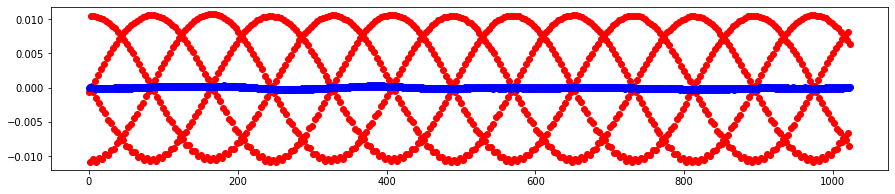

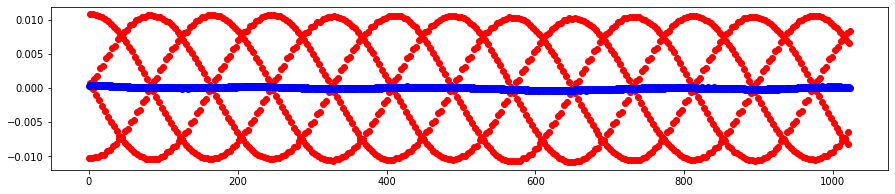

In [8]:
# Estimate parameters for signal with noise

# Set parameters
length = 8192
dtype = torch.float64
device = 'cpu'

# Set signal
t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x.add_(0.001*torch.randn(length, dtype=dtype, device=device))
x = torch.stack([x])

# Set shift size for starting position
shift = 1

# Set window
# Note, without noise window increases convergence
# With noise window amplifies noise and should be use with care if noise is large
# A possible option is to filter data or to use fractional window order
w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 0.5, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Note, noise is correlated
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    y = x[:, step*shift: step*shift + 128]
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)

# Format result (amplitude is constant, while phase is shifted)
A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples
print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), A1 - 1.00, c='red')
plt.scatter(range(limit), A2 - 1.00, c='blue')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), B1 - 0.25, c='red')
plt.scatter(range(limit), B2 - 0.25, c='blue')
plt.show()

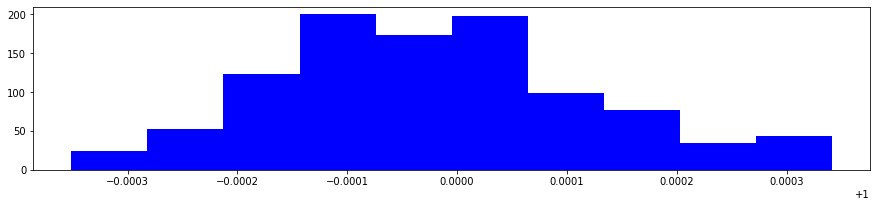

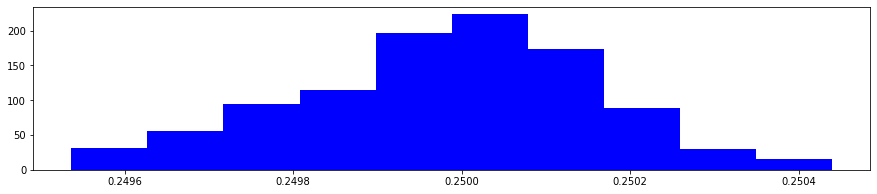

In [9]:
# Plot histogram

plt.figure(figsize=(15, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(15, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution looks somewhat not normal

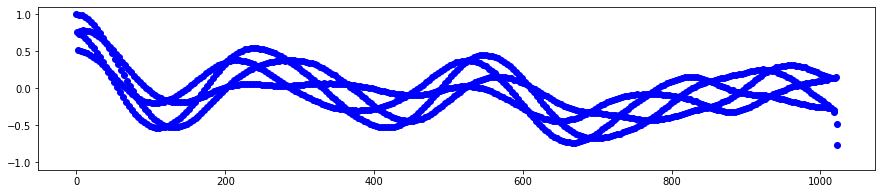

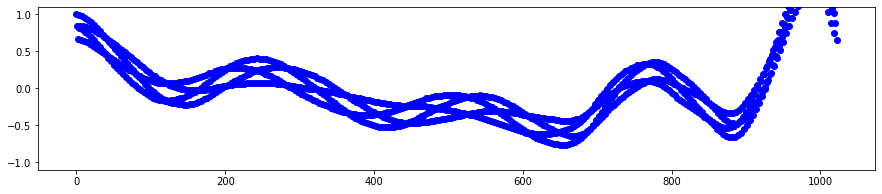

In [10]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten()
plt.figure(figsize=(15, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

# Example-04: Amplitude estimation loop

In [11]:
# In this example amplitude estimation loop is described
# Amplitude and its error is estimated for given frequency using different methods

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


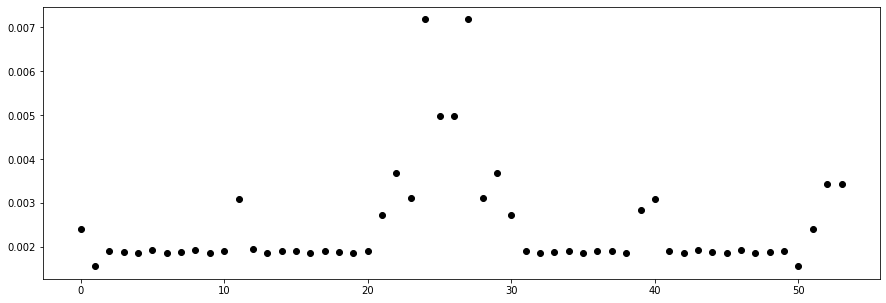

In [12]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

# Plot amplitude
plt.figure(figsize=(15, 5))
plt.scatter(range(54), amplitude.cpu(), color='black')
plt.show()

In [13]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 256 for amplitude

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882801, spread=9.83037929e-07


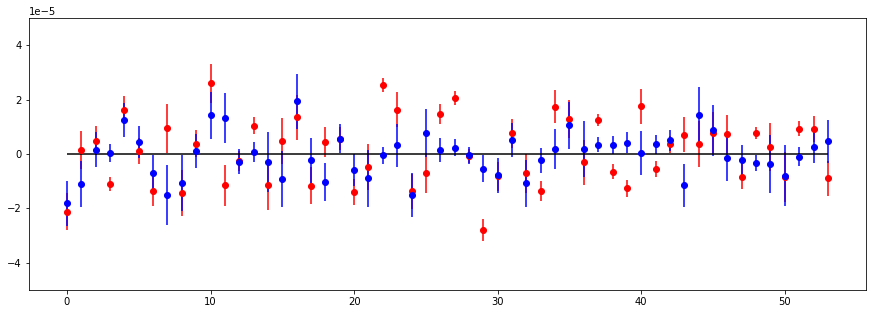

In [14]:
# Amplitude (and its error) can be estimated using harmonic_amplitude method
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation without window (noise is estimated using optimal SVD truncation)
out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=0.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread using error propogation with window
out2, err2, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Compare results
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

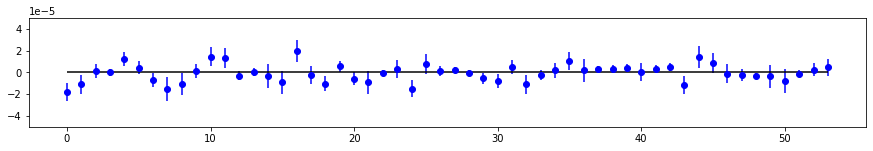

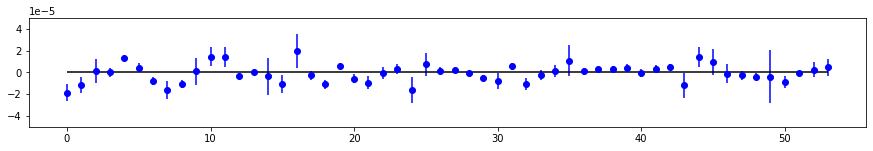

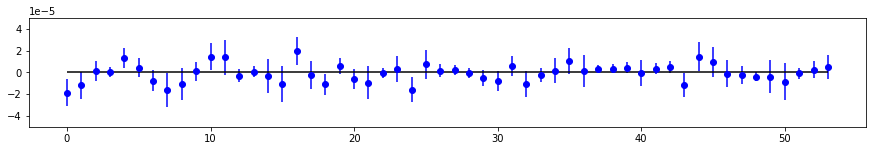

In [15]:
# Sampling can be used to improve estimation accuracy (sampling reduce effect of bias)
dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation
out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread from shifted samples
out2, err2, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

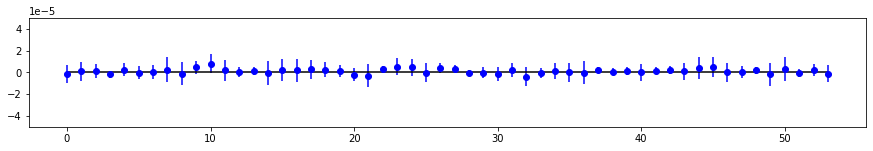

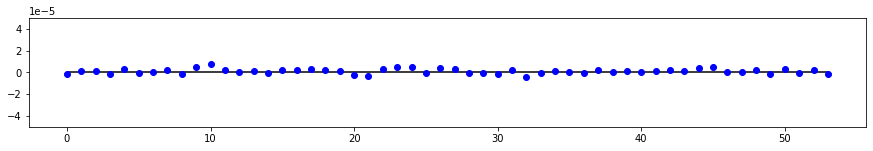

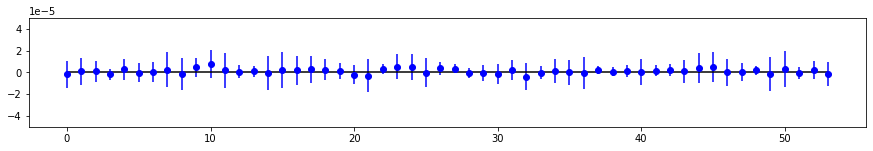

In [16]:
# Filter data
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# Estimate amplitude
dec = Decomposition(d)
out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='none')
out3, err3, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=128, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

d.reset()

# Example-05: Phase estimation loop

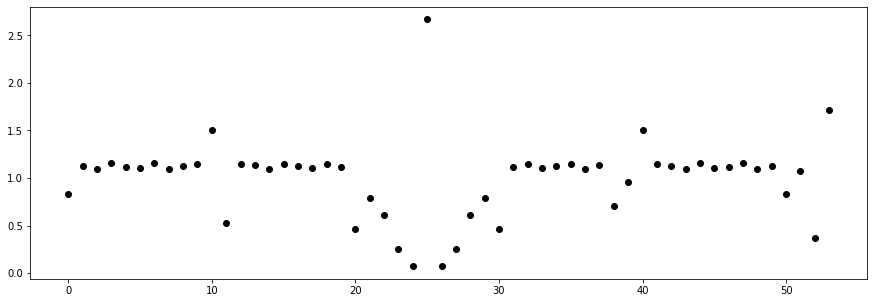

In [17]:
# Load model phase advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)

# Plot adjacent phase advance
model, _ = Decomposition.phase_adjacent(total, model)
plt.figure(figsize=(15, 5))
plt.scatter(range(54), model.cpu().numpy(), color='black')
plt.show()

In [18]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [19]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882897, spread=1.22310636e-06


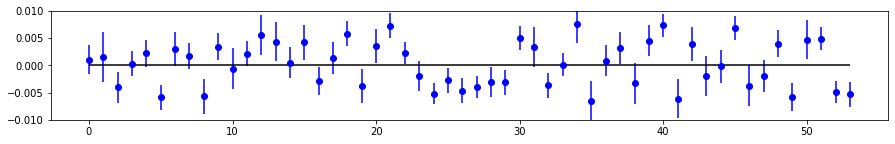

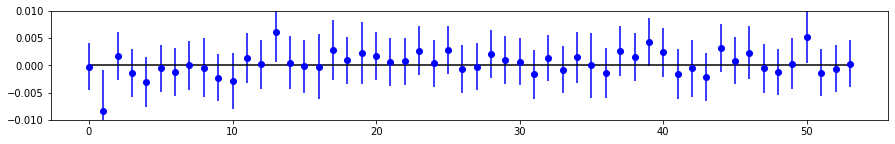

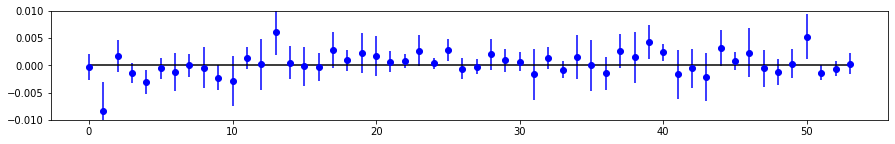

tensor(4.180334673522e-03, dtype=torch.float64)
tensor(2.266536828168e-03, dtype=torch.float64)
tensor(2.266536828168e-03, dtype=torch.float64)


In [20]:
# Estimate phase
dec = Decomposition(d)
out1, err1, _ = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

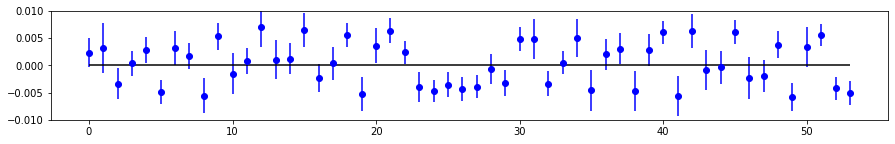

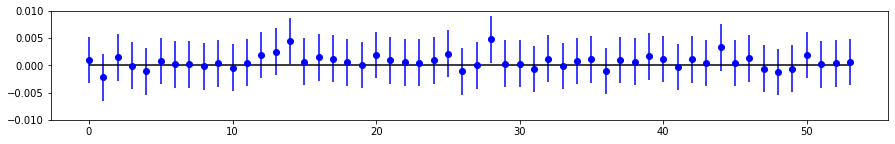

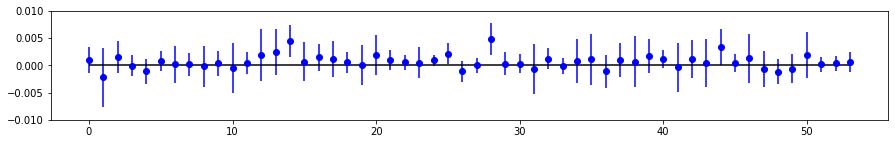

tensor(4.074539644309e-03, dtype=torch.float64)
tensor(1.272060909194e-03, dtype=torch.float64)
tensor(1.272060909194e-03, dtype=torch.float64)


In [21]:
# Estimate phase (filter)
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)
out1, err1, _ = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

d.reset()

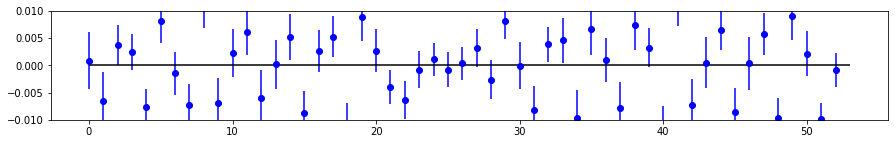

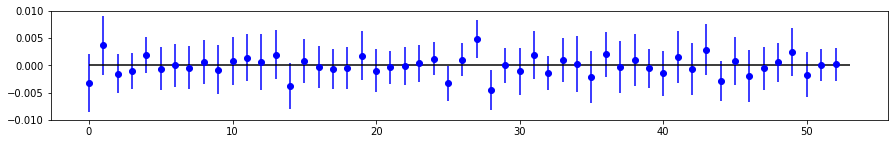

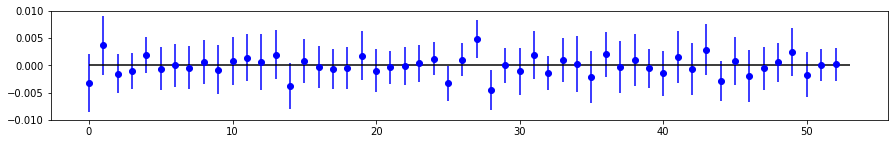

tensor(8.635765548630e-02, dtype=torch.float64)
tensor(8.711905636353e-02, dtype=torch.float64)
tensor(8.711905636353e-02, dtype=torch.float64)


In [22]:
# Compute and compare phase advance for the last case
add1, std1 = Decomposition.phase_adjacent(frequency, out1, model=False, sigma_frequency=spread, sigma_phase=err1)
add2, std2 = Decomposition.phase_adjacent(frequency, out2, model=False, sigma_frequency=spread, sigma_phase=err1)
add3, std3 = Decomposition.phase_adjacent(frequency, out3, model=False, sigma_frequency=spread, sigma_phase=err1)


plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add1 - model).cpu().numpy(), yerr=std1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add2 - model).cpu().numpy(), yerr=std2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (add3 - model).cpu().numpy(), yerr=std3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((add1 - model).std())
print((add2 - model).std())
print((add3 - model).std())

# Example-06: Synchronization check & phase correction

In [23]:
# In this example synchonization error (wrong starting turn) and corresponding phase correction is presented
# Separate function is available in Twiss class

In [24]:
# Load phase advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}
advance = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'END'])
advance = numpy.diff(advance)

In [25]:
# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
table = numpy.load('../virtual_tbt.npy')

# Set correct starting position for all signals
start = 128

# Set synchronization errors
# If shifted in + by one, need to - for correction
# If shifted in - by one, need to + for correction
error = {10: 127, 31: 129, 32:129, 41:127, 43:129}

# Set data
d = torch.zeros((54, length), dtype=dtype, device=device)
for i in range(54):
    first = start if i not in error else error[i]
    d[i] = torch.tensor(table[i, first: first + length])
d = Data.from_data(w, d)

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882954, spread=1.1664675e-06


8.536882954174649
12.536882954174647


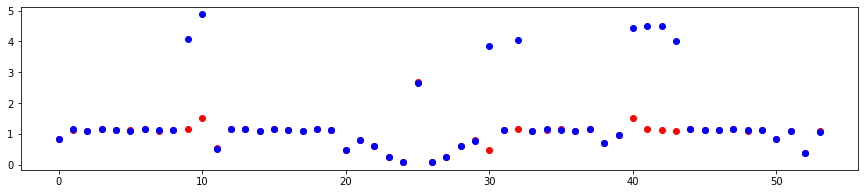

In [26]:
# Estimate phase and compute phase advance
dec = Decomposition(d)
out, _, _ = dec.harmonic_phase(frequency, length=512, order=0.0)
add, _ = Decomposition.phase_adjacent(frequency, out)

# Total advance might be used as indicator in some cases (not robust)
print((8.0 + frequency).item())
print((add.sum()/(2.0*numpy.pi)).item())

# Plot phase advance
plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

In [27]:
# To perform a more robust test & correction, the following is assumed:

# A) most of signals have no synchronization error
# B) signal can be off only by one turn in any direction
# C) without synchronization errors phase advance is close to model (some threshold can be specified)

# With these assumptions, it is possible to identify signals that might have a synchronization error
# To do this, pairs with large advance error are marked (based on robust dispersion or other methods, see below)
# Other pairs are assumed to be correct
# Signals at the endpoints are correct
# Select adjacent signal with correct phase and right marked signal, check the effect of adding or subtracting of one turn
# If such correction results in significant improvement, change corresponding phase (starting position might not be avalible)
# Do this for all marked signals

# If synchronization error is indeed present, results should match for both planes

# Ones corrected, tests can be performed again (e.g. when not all pairs are marked initialy)

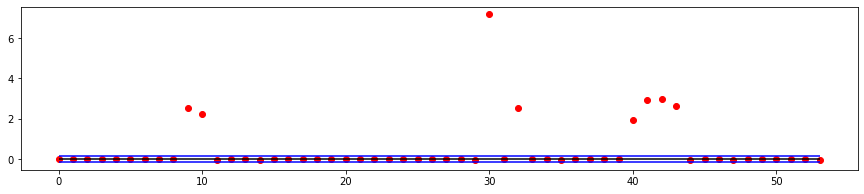

In [28]:
# Plot difference from the model model
delta = (add-advance)/advance

q25 = torch.quantile(delta, 0.25).cpu().numpy()
q50 = torch.quantile(delta, 0.50).cpu().numpy()
q75 = torch.quantile(delta, 0.75).cpu().numpy()

l, u = q25 - 10.0*(q75 - q25), q75 + 10.0*(q75 - q25)

plt.figure(figsize=(15, 3))
plt.scatter(range(54), delta.cpu().numpy(), color='red')
plt.hlines(q50, 0, 53, colors='black')
plt.hlines(l, 0, 53, colors='blue')
plt.hlines(u, 0, 53, colors='blue')
plt.show()

In [29]:
# LOF
from sklearn.neighbors import LocalOutlierFactor
detector = LocalOutlierFactor(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[30, 31], [41, 42], [42, 43]]


In [30]:
# IFO
from sklearn.ensemble import IsolationForest
detector = IsolationForest(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[26, 27], [30, 31], [40, 41]]


In [31]:
# DBSCAN
from sklearn.cluster import DBSCAN
from collections import Counter
cluster = DBSCAN().fit(delta.reshape(-1, 1))
label, *_ = Counter(cluster.labels_)
pairs, *_ = numpy.in1d(delta, delta[cluster.labels_ != label]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [32]:
# Pairs outside acceptance region
l_p, *_ = numpy.where(delta < l)
u_p, *_ = numpy.where(delta > u)
marked = (*tuple(l_p), *tuple(u_p))
marked = [[i, i + 1] for i in marked]
print(marked)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [33]:
# Marked signals
table = []
chain = []
for i in numpy.unique(numpy.array(pairs).flatten()):
    if chain == []:
        chain.append(i)
        value = i
        continue
    if i == value + 1:
        chain.append(i)
        value = i
        continue
    table.append(chain)
    chain = []
    chain.append(i)
    value = i
else:
    table.append(chain)
print(table)
    
# Remove endpoints
table = [*map(lambda x: x[1:-1], table)]
print(table)

# Set marked and passed
marked = [j for i in table for j in i]
passed = [i for i in range(54) if i not in marked]

# Set phase
phase = torch.clone(out)

# Correct
for i in marked:
    phase_x = phase[i-1]
    phase_y = phase[i]
    phase_y = phase_y + torch.stack([-2.0*numpy.pi*frequency, 0.0*numpy.pi*frequency, +2.0*numpy.pi*frequency])
    phase_y = mod(phase_y, 2*numpy.pi, -numpy.pi)
    delta = mod(phase_y - phase_x, 2*numpy.pi)
    delta = torch.abs(delta - advance[i-1])
    index = delta.argmin().item()
    print(f"{i}: {['+', ' ', '-'][index]}, {128 + [+1, 0, -1][index]}")
    phase[i] = phase_y[index]
    
print(error)

[[9, 10, 11], [30, 31, 32, 33], [40, 41, 42, 43, 44]]
[[10], [31, 32], [41, 42, 43]]
10: -, 127
31: +, 129
32: +, 129
41: -, 127
42:  , 128
43: +, 129
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


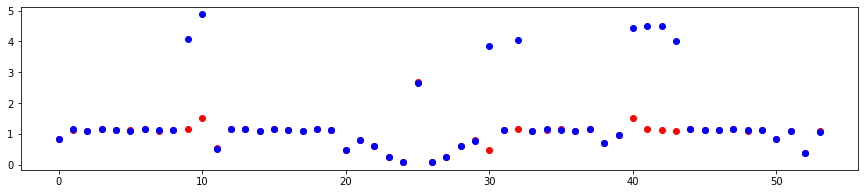

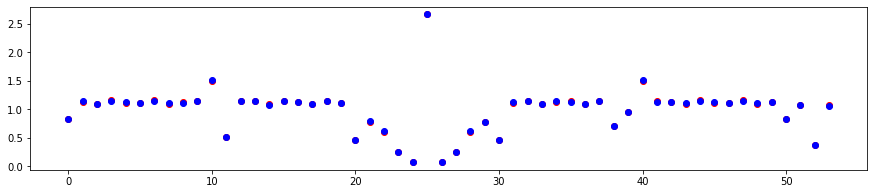

In [34]:
# Plot advance using corrected phase

plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

correct, _ = Decomposition.phase_adjacent(frequency, phase)
plt.figure(figsize=(15, 3))
plt.scatter(range(54), advance, color='red')
plt.scatter(range(54), correct, color='blue')
plt.show()

{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


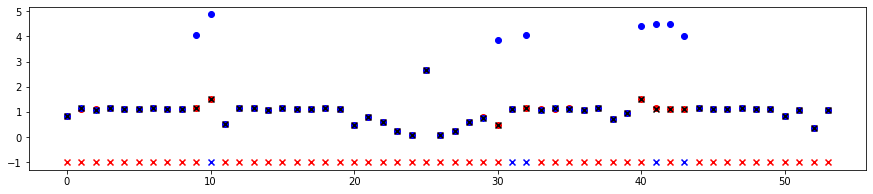

In [35]:
# phase_check classmethod can be used to perform shyncronization test
print(error)

q = frequency.item()
phase = out

Q = config['END']['FX']/(2.0*numpy.pi)
PHASE = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)

result, select = Decomposition.phase_check(q, Q, phase, PHASE, method='quantile', factor=10.0)
result = {key: value[0] + start for key, value in result.items() if value[0] != 0}
print(result)

result, select = Decomposition.phase_check(q, Q, phase, PHASE, method='dbscan', epsilon=0.5)
result = {key: value[0] + start for key, value in result.items() if value[0] != 0}
print(result)

plt.figure(figsize=(15, 3))
plt.scatter(range(54), select['model'], color='red')
plt.scatter(range(54), select['phase'], color='blue')
plt.scatter(range(54), select['check'], color='black', marker='x')
plt.scatter(*numpy.array([[index, -1.0] for index in range(54) if index not in result]).T, color='red', marker='x')
plt.scatter(*numpy.array([[index, -1.0] for index in range(54) if index in result]).T, color='blue', marker='x')
plt.show()

# Example-07: Estimation of parameters with DHT

In [36]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [37]:
# Real TbT data length is limited by decoherence

# Set window
length = 512
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882056, spread=3.14812044e-06


In [38]:
# Filter data
flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# DHT
dht = Frequency.dht(d.work)

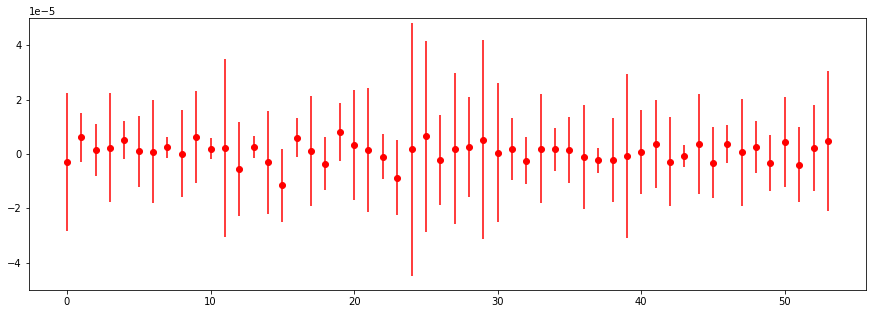

In [39]:
# Compute envelope
envelope = dht.abs()

# Estimate amplitude
endpoint = 16
estimate = envelope[:, +endpoint:-endpoint].mean(1)
spread = envelope[:, +endpoint:-endpoint].std(1)

# Compare
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (estimate - amplitude).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

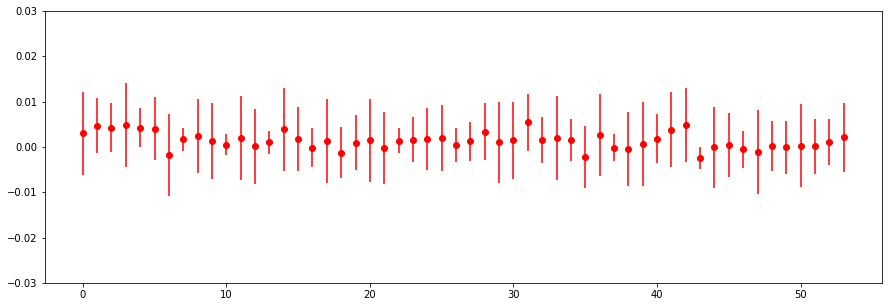

In [40]:
# Estimate phase
angle = dht.angle()
endpoint = 16
angle -= 2.0*numpy.pi*frequency*torch.linspace(0, length - 1, length, dtype=dtype, device=device)
angle = mod(angle, 2.0*numpy.pi, -numpy.pi)
estimate = angle[:, +endpoint:-endpoint].mean(1)
spread = angle[:, +endpoint:-endpoint].std(1)

# Compare
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), (estimate - phase).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-3.0E-2, +3.0E-2)
plt.show()

# Example-08: Virtual phase

In [41]:
# In this example phase is estimated for virtual locations
# Virtual locations are locations where TbT data is not avalible, e.g. fault BPMs or other locations of interest
# Locations where TbT data is avalible, i.e. phase can be computed from TbT data, are denoted as monitors
# Using measured phase at monitors and model phase advance data, phase at a virtual location can be computed
# It is also possible to treat a monitor location as a virtual location
# In this case, phase estimation accuracy can be improved in some cases

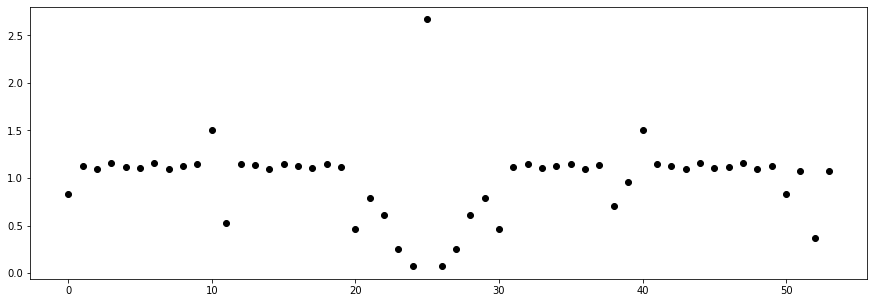

In [42]:
# Load model phase advance data
# Note, only monitor locations are selected, a subset of monitors will be demoted to virtual locations later
# Note, model phase advance error is given for each location (virtual or monitor), it corresponds to an error from given location to the next one

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)
error = 1.0E-4*torch.ones_like(model)

# Plot adjacent phase advance

model_advance, error_advance = Decomposition.phase_adjacent(total/(2.0*numpy.pi), model, model=True, sigma_phase=error)
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), model_advance.cpu().numpy(), yerr=error_advance.cpu().numpy(), color='black', fmt=' ', marker='o')
plt.show()

In [43]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [44]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883097, spread=1.13143473e-06


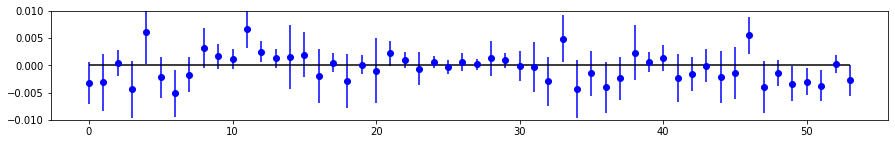

tensor(2.714691584952e-03, dtype=torch.float64)


In [45]:
# Estimate phase

dec = Decomposition(d)
phase_estimate, error_estimate, _ = dec.harmonic_phase(frequency, length=256, order=1.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((phase_estimate - phase).std())

location=5
monitor: [error, sigma] = [0.0021904985083924244, 0.003709811397638196]
virtual: [error, sigma] = [0.00030178468892044785, 0.00018202300477945902]


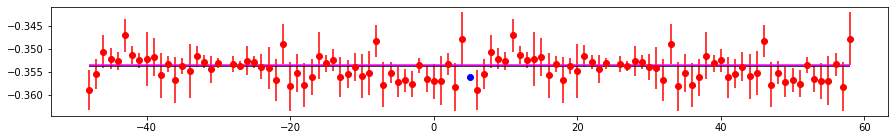

location=25
monitor: [error, sigma] = [0.00023356555818693225, 0.001309938127429341]
virtual: [error, sigma] = [0.0002862080668718514, 0.00018216034840790821]


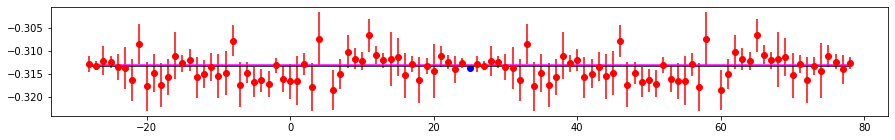

In [46]:
# Virtual phase

# Set demoted location
# Note, location index starts from zero
index = [5, 25]

# Set location flags, 0/1 for virtual/monitor locations
flags = torch.ones_like(model, dtype=torch.int32)
flags[index] = 0

# Set measured & model frequency with errors
q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors
phase_measured = torch.clone(phase_estimate)
error_measured = torch.clone(error_estimate)
phase_measured[index] = 0.0
error_measured[index] = 0.0

# Set model phase with error
phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit
limit = 54

# Estimate virtial phase for each virtual location
for location in index:
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model, 
                              sigma_q=sigma_q, sigma_Q=sigma_Q, sigma_phase=error_measured, sigma_PHASE=error_model,
                              full=True, clean=True, fit=True)
    
    # Compare fit result with model
    print(f'{location=}')
    print(f'monitor: [error, sigma] = {[abs(phase[location] - phase_estimate[location]).item(), error_estimate[location].item()]}')
    print(f'virtual: [error, sigma] = {[abs(phase[location] - result["model"][0]).item(), result["model"][1]]}')
    
    # Plot data for all locations
    plt.figure(figsize=(15, 2))
    plt.errorbar(list(result['index']), result['phase'], yerr=result['error'], color='red', fmt=' ', marker='o')
    plt.scatter(location, phase_estimate[location].item(), color='blue')
    plt.hlines(phase[location].item(), min(result['index'].keys()), max(result['index'].keys()), color='black')
    plt.hlines(result['model'][0], min(result['index'].keys()), max(result['index'].keys()), color='magenta')
    
    plt.show()
    
# red     -- estimation using different monitors 
# blue    -- estimation from TbT
# black   -- reference value
# magenta -- fitted value

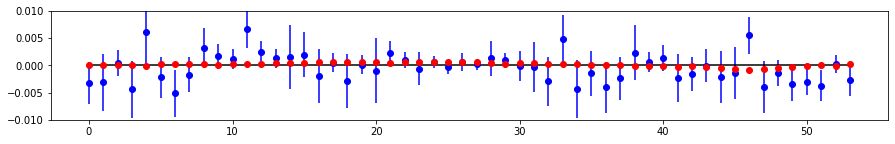

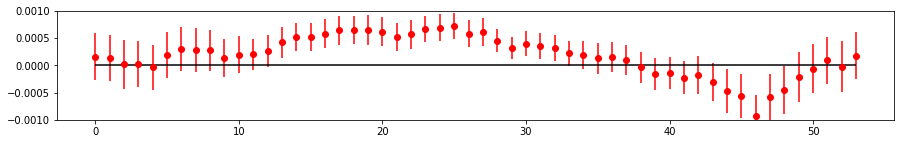

tensor(2.714691584952e-03, dtype=torch.float64)
tensor(3.721765814532e-04, dtype=torch.float64)


In [47]:
# Virtual phase for monitors

# Note, change limit value

# Set location flags, 0/1 for virtual/monitor locations
flags = torch.ones_like(model, dtype=torch.int32)

# Set measured & model frequency with errors
q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors
phase_measured = torch.clone(phase_estimate)
error_measured = torch.clone(error_estimate)

# Set model phase with error
phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit
limit = 16

# Estimate virtial phase for each virtual location
out = []
for location in range(len(flags)):
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model, 
                              sigma_q=sigma_q, sigma_Q=sigma_Q, sigma_phase=error_measured, sigma_PHASE=error_model,
                              full=True, clean=True, fit=True)
    out.append(result['model'])
    
phase_virtual, error_virtual = torch.tensor(numpy.array(out).T)

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-3, +1.0E-3)
plt.show()

print((phase_estimate - phase).std())
print((phase_virtual - phase).std())

# Note, such 'correction' introduces bias, use with error estimates with care, adjust limit

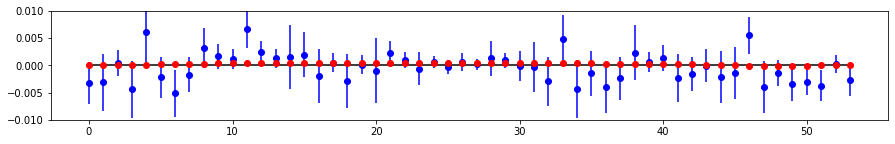

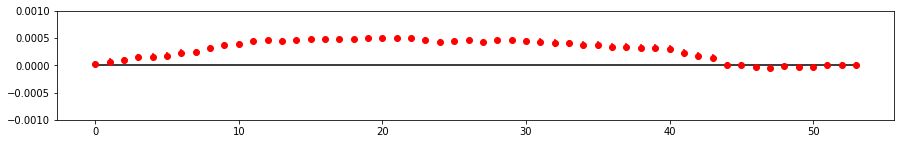

tensor(2.714691584952e-03, dtype=torch.float64)
tensor(1.902316885800e-04, dtype=torch.float64)


In [48]:
# Virtual phase for monitors (second pass)

# Note, second pass (or more) impoves std in general
# Note, change limit value

# Set location flags, 0/1 for virtual/monitor locations
flags = torch.ones_like(model, dtype=torch.int32)

# Set measured & model frequency with errors
q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors
phase_measured = torch.clone(phase_virtual)
error_measured = torch.clone(error_estimate)

# Set model phase with error
phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit
limit = limit

# Estimate virtial phase for each virtual location
out = []
for location in range(len(flags)):
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model, 
                              sigma_q=sigma_q, sigma_Q=sigma_Q, sigma_phase=error_measured, sigma_PHASE=error_model,
                              full=True, clean=True, fit=True)
    out.append(result['model'])
    
phase_virtual, error_virtual = torch.tensor(numpy.array(out).T)

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

# Note, such 'correction' introduces bias, use with care, adjust limit
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-3, +1.0E-3)
plt.show()

print((phase_estimate - phase).std())
print((phase_virtual - phase).std())

In [13]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, data_load, generate_pairs
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


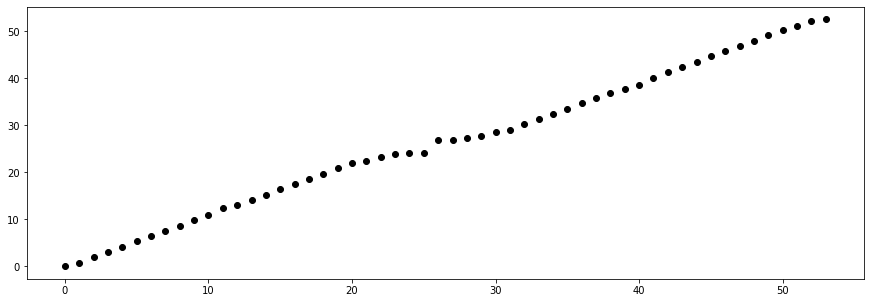

In [2]:
# Model advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}
    
total = config['END']['FX']
model = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'])
plt.figure(figsize=(15, 5))
plt.scatter(range(len(model)), model, color='black')
plt.show()
model = torch.tensor(model, dtype=torch.float64)

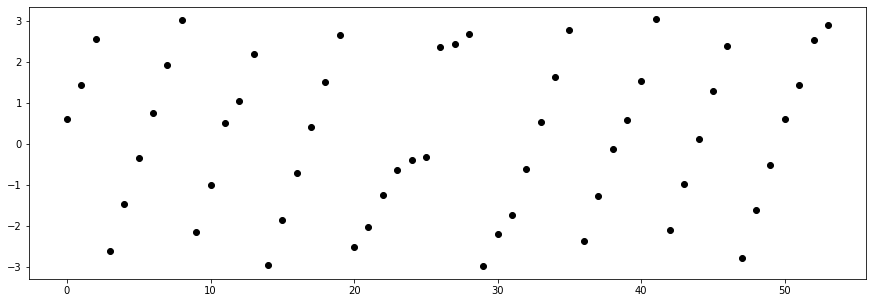

In [3]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude and phase for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

plt.figure(figsize=(15, 5))
plt.scatter(range(len(phase)), phase, color='black')
plt.show()

In [4]:
def advance(i:int, j:int, total:float, table:torch.Tensor) -> torch.Tensor:
    """
    Compute phase advance mod 2*pi between i and j locations.
    
    Note, phase advance is computed from i to j, if i > j, phase advance is negative

    Parameters
    ----------
    i: int
        probed location
    j: int
        second location
    total: float
        total phase advane for one turn (fractional part)
    table: torch.Tensor
        model phase advance data or measured phase data

    Returns
    -------
    phase advance mod 2*pi and optional error (torch.Tensor)
    
    """
    size, *_ = table.shape
    if i < j:
        i_index, j_index = int(Frequency.mod(i, size)), int(Frequency.mod(j, size))
        i_count, j_count = (i - i_index)//size, (j - j_index)//size
        i_phase, j_phase = table[i_index] + i_count*total, table[j_index] + j_count*total
        return Frequency.mod(j_phase - i_phase, 2.0*numpy.pi)
    return -advance(j, i, total, table)


def advance_error(i:int, j:int, error:torch.Tensor) -> tuple:
    """
    Compute phase advance error between i and j locations.
    
    Note, frequency error is ignored

    Parameters
    ----------
    i: int
        probed location
    j: int
        second location
    error: torch.Tensor
        error data

    Returns
    -------
    phase advance error (torch.Tensor)
    
    """
    size, *_ = error.shape
    i_index, j_index = int(Frequency.mod(i, size)), int(Frequency.mod(j, size))
    i_error, j_error = error[i_index], error[j_index]
    return torch.sqrt(i_error**2 + j_error**2)


def advance_adjacent(total:float, table:torch.Tensor, error:torch.Tensor=None) -> tuple:
    """
    Compute phase advance mod 2*pi between adjacent locations.

    Parameters
    ----------
    total: float
        total phase advane for one turn (fractional part)
    table: torch.Tensor
        model phase advance data or measured phase data
    error: torch.Tensor
        error data

    Returns
    -------
    adjacent phase advance mod 2*pi and optional error (torch.Tensor, torch.Tensor)
    
    """
    size, *_ = table.shape
    data = torch.stack([advance(i, i + 1, total, model) for i in range(size)])
    if error == None:
        return (data, None)
    return (data, torch.stack([advance_error(i, i + 1, error) for i in range(size)]))

In [5]:
r1, _ = advance_adjacent(total, model)
r2, _ = advance_adjacent(2.0*numpy.pi*frequency, phase)

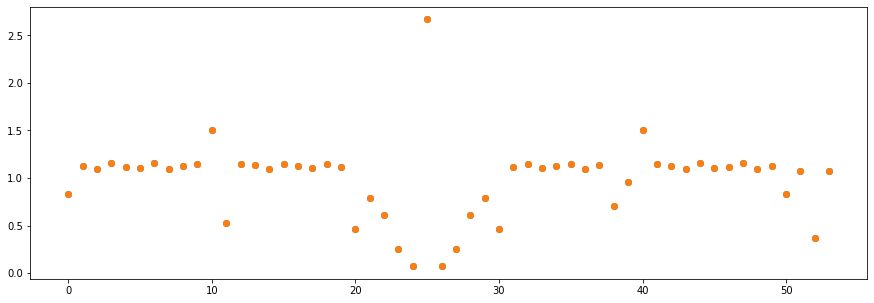

In [6]:
plt.figure(figsize=(15, 5))
plt.scatter(range(54), r1)
plt.scatter(range(54), r2)
plt.show()

In [7]:
def combo(limit:int):
    table = [*range(-limit, 1 + limit)]
    table.remove(0)
    table = [[0, i] for i in table]
    out = []
    for i in range(0, len(table)):
        for j in range(i + 1, len(table)):
            out.append([table[i], table[j]])
    out = sorted(out, key=lambda x: max(map(lambda y: list(map(abs, y)), x)))
    return torch.tensor(numpy.array(out)) # dtype long, device from self

combo(1)

tensor([[[ 0, -1],
         [ 0,  1]]])

In [ ]:
# TEST

In [255]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, data_load
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


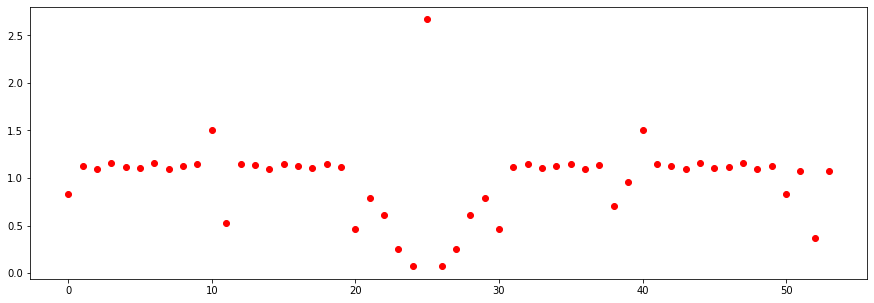

In [256]:
# Generate model adjacent advance between monitors

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)
model, _ = Decomposition.advance_adjacent(total, model)
model = model.numpy()

plt.figure(figsize=(15, 5))
plt.scatter(range(54), model, color='red')
plt.show()

In [257]:
# Generate test data with noise and estimate frequency

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
table = numpy.load('../virtual_tbt.npy')

# Set correct starting position for all signals
start = 128

# Set synchronization errors
# If shifted in + by one, need to - for correction
# If shifted in - by one, need to + for correction
error = {10: 127, 31: 129, 32:129, 41:127, 43:129}

# Set data
d = torch.zeros((54, length), dtype=dtype, device=device)
for i in range(54):
    first = start if i not in error else error[i]
    d[i] = torch.tensor(table[i, first: first + length])
d = Data.from_data(w, d)

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883016, spread=1.20641506e-06


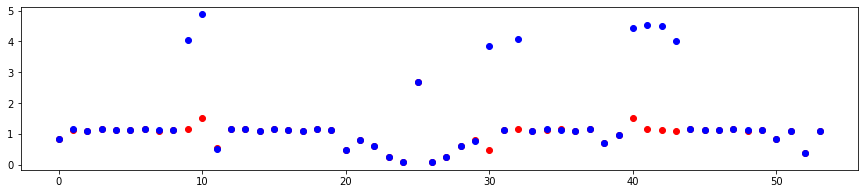

In [258]:
# Estimate phase and compute adjacent phase advance
dec = Decomposition(d)
out, _ = dec.harmonic_phase(frequency, length=512, order=0.0)
add, _ = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, out)

# Plot phase advance
plt.figure(figsize=(15, 3))
plt.scatter(range(54), model, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

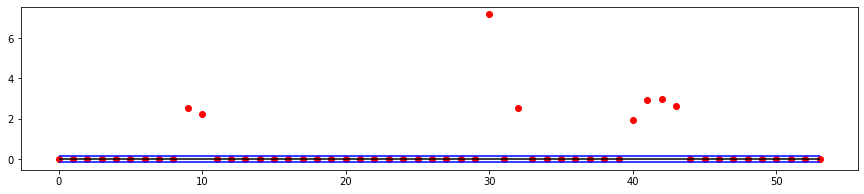

In [259]:
# Plot difference from the model model
delta = (add-model)/model

q25 = torch.quantile(delta, 0.25).cpu().numpy()
q50 = torch.quantile(delta, 0.50).cpu().numpy()
q75 = torch.quantile(delta, 0.75).cpu().numpy()

# Note, 10.0 is a 'parameter'
p = 10.0
l, u = q25 - p*(q75 - q25), q75 + p*(q75 - q25)

plt.figure(figsize=(15, 3))
plt.scatter(range(54), delta.cpu().numpy(), color='red')
plt.hlines(q50, 0, 53, colors='black')
plt.hlines(l, 0, 53, colors='blue')
plt.hlines(u, 0, 53, colors='blue')
plt.show()

In [260]:
# LOF
from sklearn.neighbors import LocalOutlierFactor
detector = LocalOutlierFactor(contamination=0.1)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[9, 10], [30, 31], [32, 33], [41, 42], [42, 43], [43, 44]]


In [261]:
# IFO
from sklearn.ensemble import IsolationForest
detector = IsolationForest(contamination=0.1)
pairs = detector.fit_predict(delta.reshape(-1, 1))
pairs, *_ = numpy.in1d(delta, delta[pairs == -1]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[10, 11], [30, 31], [40, 41], [41, 42], [42, 43], [43, 44]]


In [262]:
# DBSCAN
from sklearn.cluster import DBSCAN
from collections import Counter
cluster = DBSCAN().fit(delta.reshape(-1, 1))
label, *_ = Counter(cluster.labels_)
pairs, *_ = numpy.in1d(delta, delta[cluster.labels_ != label]).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [263]:
# Pairs outside acceptance region
l_p, *_ = numpy.where(delta < l)
u_p, *_ = numpy.where(delta > u)
marked = (*tuple(l_p), *tuple(u_p))
marked = [[i, i + 1] for i in marked]
print(marked)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [264]:
# Marked signals
table = []
chain = []
for i in numpy.unique(numpy.array(pairs).flatten()):
    if chain == []:
        chain.append(i)
        value = i
        continue
    if i == value + 1:
        chain.append(i)
        value = i
        continue
    table.append(chain)
    chain = []
    chain.append(i)
    value = i
else:
    table.append(chain)
print(table)
    
# Remove endpoints
table = [*map(lambda x: x[1:-1], table)]
print(table)

# Set marked and passed
marked = [j for i in table for j in i]
passed = [i for i in range(54) if i not in marked]
print('marked')
print(marked)

print('passed')
print(passed)

[[9, 10, 11], [30, 31, 32, 33], [40, 41, 42, 43, 44]]
[[10], [31, 32], [41, 42, 43]]
marked
[10, 31, 32, 41, 42, 43]
passed
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [265]:
# Set phase
phase = torch.clone(out)

# Correct
for i in marked:
    phase_x = phase[i-1]
    phase_y = phase[i]
    phase_y = phase_y + torch.stack([-2.0*numpy.pi*frequency, 0.0*numpy.pi*frequency, +2.0*numpy.pi*frequency])
    phase_y = Frequency.mod(phase_y, 2*numpy.pi, -numpy.pi)
    delta = Frequency.mod(phase_y - phase_x, 2*numpy.pi)
    delta = torch.abs(delta - model[i-1])
    index = delta.argmin().item()
    print(f"{i}: {['+', ' ', '-'][index]}, {128 + [+1, 0, -1][index]}")
    phase[i] = phase_y[index]
    
print(error)

10: -, 127
31: +, 129
32: +, 129
41: -, 127
42:  , 128
43: +, 129
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


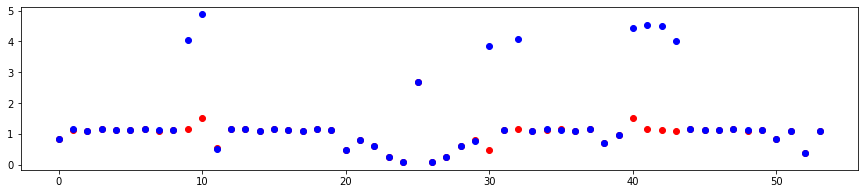

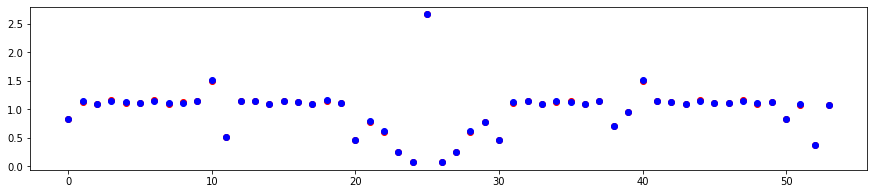

In [266]:
# Plot advance using corrected phase

plt.figure(figsize=(15, 3))
plt.scatter(range(54), model, color='red')
plt.scatter(range(54), add, color='blue')
plt.show()

correct, _ = Decomposition.advance_adjacent(2.0*numpy.pi*frequency, phase)
plt.figure(figsize=(15, 3))
plt.scatter(range(54), model, color='red')
plt.scatter(range(54), correct, color='blue')
plt.show()

In [267]:
# Use all passed for each marked
Q = total
q = 2.0*numpy.pi*frequency.item()

data_model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)
data_phase = torch.clone(out)

table = []
table_phase = []
for candidate in marked:
    
    local = []
    
    local_model = torch.stack([Decomposition.advance(candidate, other, Q, data_model) for other in passed])
    
    # -1
    local_phase = torch.clone(data_phase)
    phase_a = Frequency.mod(local_phase[candidate]+q, 2*numpy.pi, -numpy.pi)
    local_phase[candidate] = phase_a
    local_phase = torch.stack([Decomposition.advance(candidate, other, q, local_phase) for other in passed])
    local_phase = torch.sum((local_model - local_phase)**2)
    local.append(local_phase)
    
    # 0
    local_phase = torch.clone(data_phase)
    phase_b = Frequency.mod(local_phase[candidate], 2*numpy.pi, -numpy.pi)
    local_phase[candidate] = phase_b
    local_phase = torch.stack([Decomposition.advance(candidate, other, q, local_phase) for other in passed])
    local_phase = torch.sum((local_model - local_phase)**2)
    local.append(local_phase)
    
    # +1
    local_phase = torch.clone(data_phase)
    phase_c = Frequency.mod(local_phase[candidate]-q, 2*numpy.pi, -numpy.pi)
    local_phase[candidate] = phase_c
    local_phase = torch.stack([Decomposition.advance(candidate, other, q, local_phase) for other in passed])
    local_phase = torch.sum((local_model - local_phase)**2)
    local.append(local_phase)
    
    # add
    table.append(torch.stack(local))
    table_phase.append(torch.stack([phase_a, phase_b, phase_c]))

table = torch.stack(table)
print(table)
index = torch.argmin(table, 1)
print(index- 1)
# -1, +1, +1, -1, 0, +1

table_phase = torch.stack(table_phase)
correct = torch.stack([data[i] for i, data in zip(index, table_phase)])

result = torch.clone(data_phase)
result[marked] = correct

tensor([[1.968746764745e-03, 4.733607535527e+02, 7.783956511612e+01],
        [1.109777168687e+02, 4.702136386391e+02, 2.316655487646e-03],
        [1.451201515901e+02, 4.616826317702e+02, 1.513115552255e-03],
        [1.976902398405e-03, 4.618569434586e+02, 1.783770623610e+02],
        [4.819956779808e+02, 1.670075156025e-03, 4.676437719089e+02],
        [1.113568909752e+02, 4.704247249958e+02, 1.035465680380e-03]],
       dtype=torch.float64)
tensor([-1,  1,  1, -1,  0,  1])


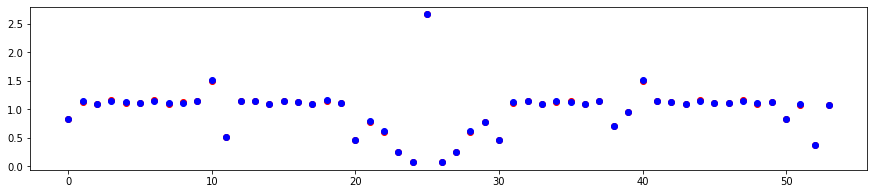

In [268]:
tmp_model, _ = Decomposition.advance_adjacent(Q, data_model)
tmp_phase, _ = Decomposition.advance_adjacent(q, result)
plt.figure(figsize=(15, 3))
plt.scatter(range(54), tmp_model, color='red')
plt.scatter(range(54), tmp_phase, color='blue')
plt.show()

In [ ]:
def check_synhronization(q real tune, Q model tune, model, phase, method, method parameter, number of passes, use all, drop end points flag,  model tolerance?)
return -1/0/+1 for all and corrected phase

In [269]:
q = frequency.item()
Q = total/(2.0*numpy.pi)
print(q, Q)

data_model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)
data_phase = torch.clone(out)

0.5368830164233898 8.536883098737361


In [332]:
@classmethod
def advance_check(cls, q:float, Q:float, phase:torch.Tensor, PHASE:torch.Tensor, *,
                  method:str='quantile', factor:float=10.0, epsilon:float=0.5,
                  remove:bool=True, **kwargs) -> dict:
    """
    Perform synchronization check based on adjacent locations advance diffrence with model values.

    Only one turn error is checked
    Empty dict is returned if all locations pass

    Parameters
    ----------
    q: float
        measured tune
    Q: float
        model tune
    phase: torch.Tensor
        measured phase data
    PHASE: torch.Tensor
        model phase data
    method: str
        detection method ('quantile' or 'dbscan')
    factor: float
        factor for quantile method
    epsilon: float
        epsilon for dbscan method
    remove: bool
        flag to remove endpoints
    **kwargs:
        passed to 

    Returns
    -------
    {marked: (shift, phase)}

    """
    
    advance_phase, _ = Decomposition.advance_adjacent(2.0*numpy.pi*q, phase)
    advance_model, _ = Decomposition.advance_adjacent(2.0*numpy.pi*Q, PHASE)
    advance_error = (advance_phase - advance_model)/advance_model
    
    if method == 'dbscan':
        from sklearn.cluster import DBSCAN
        from collections import Counter
        advance_error = advance_error.cpu().numpy()
        group = DBSCAN(eps=epsilon, **kwargs).fit(advance_error.reshape(-1, 1))
        label, *_ = Counter(group.labels_)
        pairs, *_ = numpy.in1d(advance_error, advance_error[group.labels_ != label]).nonzero()
        pairs = [[i, i + 1] for i in tuple(pairs)]
        
    if method == 'quantile':
        q_25 = torch.quantile(advance_error, 0.25).cpu().numpy()
        q_75 = torch.quantile(advance_error, 0.75).cpu().numpy()
        q_l = q_25 - factor*(q_75 - q_25)
        q_u = q_75 + factor*(q_75 - q_25)
        advance_error = advance_error.cpu().numpy()
        pairs_l, *_ = numpy.where(advance_error < q_l)
        pairs_u, *_ = numpy.where(advance_error > q_u)
        pairs = (*tuple(pairs_l), *tuple(pairs_u))
        pairs = [[i, i + 1] for i in pairs]
    
    if pairs == []:
        return {}
    
    table = []
    chain = []
    for i in numpy.unique(numpy.array(pairs).flatten()):
        if chain == []:
            chain.append(i)
            value = i
            continue
        if i == value + 1:
            chain.append(i)
            value = i
            continue
        table.append(chain)
        chain = []
        chain.append(i)
        value = i
    else:
        table.append(chain)
    
    if remove:
        table = [*map(lambda chain: chain[1:-1], table)]
        
    marked = [j for i in table for j in i]
    passed = [i for i in range(len(phase)) if i not in marked]
    
    result = {}
    
    for index in marked:
        
        local_model = torch.stack([Decomposition.advance(index, other, 2.0*numpy.pi*Q, PHASE) for other in passed])
        
        local_phase = torch.clone(phase)
        phase_x = Frequency.mod(local_phase[index] + 1.0*2.0*numpy.pi*q, 2*numpy.pi, -numpy.pi).cpu().item()
        local_phase[index] = phase_x
        local_phase = torch.stack([Decomposition.advance(index, other, 2.0*numpy.pi*q, local_phase) for other in passed])
        error_x = torch.sum((local_model - local_phase)**2)
        
        local_phase = torch.clone(phase)
        phase_y = Frequency.mod(local_phase[index] + 0.0*2.0*numpy.pi*q, 2*numpy.pi, -numpy.pi).cpu().item()
        local_phase[index] = phase_y
        local_phase = torch.stack([Decomposition.advance(index, other, 2.0*numpy.pi*q, local_phase) for other in passed])
        error_y = torch.sum((local_model - local_phase)**2)
        
        local_phase = torch.clone(phase)
        phase_z = Frequency.mod(local_phase[index] - 1.0*2.0*numpy.pi*q, 2*numpy.pi, -numpy.pi).cpu().item()
        local_phase[index] = phase_z
        local_phase = torch.stack([Decomposition.advance(index, other, 2.0*numpy.pi*q, local_phase) for other in passed])
        error_z = torch.sum((local_model - local_phase)**2)
        
        error = torch.stack([error_x, error_y, error_z]).argmin().item()
        result[index] = (error - 1, [phase_x, phase_y, phase_z][error])
        
    return result

In [ ]:
# Generation of combinations

In [193]:
# def combo(limit:int):
#     table = [*range(-limit, 1 + limit)]
#     table.remove(0)
#     table = [[0, i] for i in table]
#     out = []
#     for i in range(0, len(table)):
#         for j in range(i + 1, len(table)):
#             out.append([table[i], table[j]])
# #     out = sorted(out, key=lambda x: max(map(lambda y: list(map(abs, y)), x)))
# #     return torch.tensor(numpy.array(out)) # dtype long, device from self
#     return out

# print(combo(2))

from itertools import combinations
def generate_pairs(limit:int, count:int) -> list:
    """
    Generate combinations of unique pairs of probed locatiaon and other locations.
    
    Probed location has index 0, other locations are in range defined by limit
    
    Parameters
    ----------
    limit: int
        maximum distance from probed location
    count: int
        number of unique locations in combination

    Returns
    -------
    [..., [sum_i, combination_i], ...] sorted by sum_i
    
    """
    other = [i for i in range(-limit, 1 + limit) if i != 0]
    pairs = [(0, i) for i in other]
    stock = {pair: abs(sum(pair)) for pair in pairs}
    combo = list(combinations(pairs, count))
    stock = [sum(stock[j] for j in i) for i in combo]
    combo = [[stock, list(map(list, combo))] for combo, stock in zip(combo, stock)]
    return sorted(combo)

generate_pairs(2, 2)

[[2, [[0, -1], [0, 1]]],
 [3, [[0, -2], [0, -1]]],
 [3, [[0, -2], [0, 1]]],
 [3, [[0, -1], [0, 2]]],
 [3, [[0, 1], [0, 2]]],
 [4, [[0, -2], [0, 2]]]]

In [12]:
generate_pairs(2, 2)

[[2, [[0, -1], [0, 1]]],
 [3, [[0, -2], [0, -1]]],
 [3, [[0, -2], [0, 1]]],
 [3, [[0, -1], [0, 2]]],
 [3, [[0, 1], [0, 2]]],
 [4, [[0, -2], [0, 2]]]]

In [41]:
# Import

import epics
import numpy
import pandas
import torch
import nufft
import yaml

import sys
sys.path.append('..')

from harmonica.util import LIMIT, data_load, generate_pairs, mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


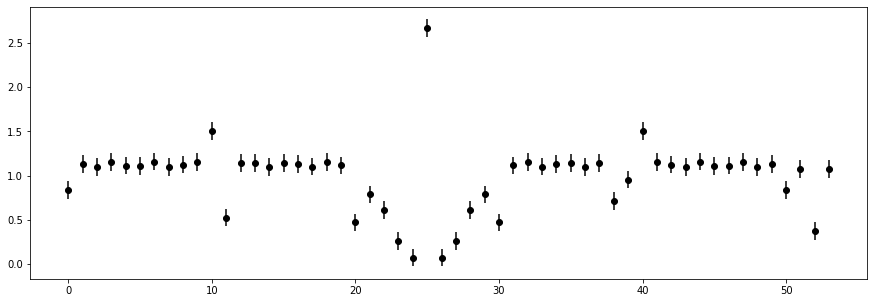

In [42]:
# Load model phase advance data
with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)
error = 1.0E-1*torch.ones_like(model)
# Plot adjacent phase advance
model, error = Decomposition.phase_adjacent(total/(2.0*numpy.pi), model, model=True, sigma_phase=error)
plt.figure(figsize=(15, 5))
plt.errorbar(range(54), model.cpu().numpy(), yerr=error.cpu().numpy(), color='black', fmt=' ', marker='o')
plt.show()

In [43]:
# Estimate reference parameters

# Set window
length = 4096
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency
h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error
result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a, b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.38725499e-16, error=2.56151871e-13


In [44]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window
length = 1024
dtype = torch.float64
device = 'cpu'
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data
d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise
n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)
f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883088, spread=9.88277544e-07


In [45]:
print(mod(phase[0] + 2.0*numpy.pi*frequency, 2.0*numpy.pi, -numpy.pi))
print(Decomposition.phase_adjust(0 + 54, frequency, phase))

tensor(-2.313821233715e+00, dtype=torch.float64)
tensor([-2.313821233715e+00, 0.000000000000e+00], dtype=torch.float64)


In [46]:
print(mod(phase[0] - 2.0*numpy.pi*frequency, 2.0*numpy.pi, -numpy.pi))
print(Decomposition.phase_adjust(0 - 54, frequency, phase))

tensor(-2.777307786796e+00, dtype=torch.float64)
tensor([-2.777307786796e+00, 0.000000000000e+00], dtype=torch.float64)


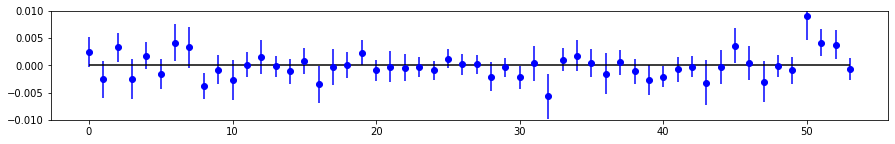

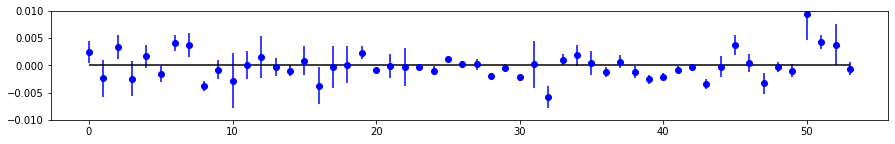

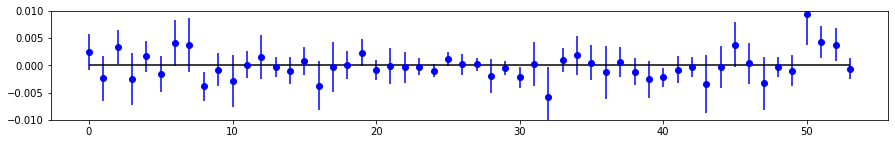

tensor(2.465699296767e-03, dtype=torch.float64)
tensor(2.533488276958e-03, dtype=torch.float64)
tensor(2.533488276958e-03, dtype=torch.float64)


In [47]:
# Estimate phase
dec = Decomposition(d)
out1, err1, _ = dec.harmonic_phase(frequency, length=512, order=1.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_phase(frequency, length=256, order=1.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='none')
out3, err3, _ = dec.harmonic_phase(frequency, length=256, order=1.0, error=True, sigma_frequency=spread, shift=True, count=256, step=1, fit='average')

# Compare results
plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

print((out1 - phase).std())
print((out2 - phase).std())
print((out3 - phase).std())

In [48]:
# MODEL ADVANCE

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}

total = config['END']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=torch.float64)

In [49]:
# MEASURED PHASE & ERROR ESTIMATE
# out3
# err3

In [50]:
i, j = -1,  4
print(Decomposition.phase_advance(i, j, total/(2.0*numpy.pi), model))
print(Decomposition.phase_advance(i, j, total/(2.0*numpy.pi), phase))
mod(total, 2.0*numpy.pi)

tensor([5.298121435853e+00, 0.000000000000e+00], dtype=torch.float64)
tensor([5.298121435854e+00, 0.000000000000e+00], dtype=torch.float64)


3.3733359976596375

In [51]:
# set model data for all locations including virtual
# set measured phase (monitor locations)
# task is to find phase at virtual locations

In [52]:
# 0) use advance from virtual to other (first check adjacent for sign?)
# 1) get indeces of monitors in model data
# 2) get adjacent monitors, find phase using adjacent (sign?)
# 3) use all other, find phase and error
# 4) do wls
# 5) monitor <--> weights (additional?)

In [53]:
def virtual_phase(index, model, local, phase, sigma):
    pass

# index -- index of virtual location in model data
# model -- model phase data for all location (all monitor and all virtual)
# local -- list of indeces of monitor locations in model data
# phase -- monitor locations phase list
# signa -- (optional) monitor location error list

In [54]:
# DETAILS

# add different computation mods
# 1) adjacent
# 2) one-turn
# 3) range

# add sigma of sector (each sector between all locations virtual and monitor)

# do not fit inside? if impove, need to add original data

# add frequency error for going to other turn?

# for range mode generarate indeces inside

# NEED function to compute PHASE on other turns
# USE it in ADVANCE function

# need some data trimming by quantile

[0, 1, 5, 10, 15]
[-5.5286007617616484e-05, 0.0025712208728539154]
[0.00013216104516788896, 0.00023589904600808967]
[-0.0024508729041300414, 0.0032727979686172385]


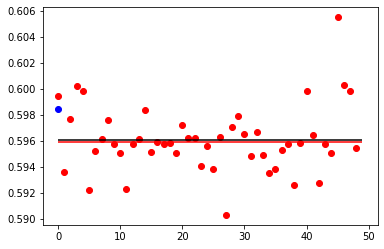

In [55]:
# test data

# model advance for all locations (monitor & virtual)
data_model = torch.clone(model)

# define indices of virtial
data_index = [0, 1, 5, 10, 15]

# generate local (ids of monitor in data_model)
data_local = [i for i in range(len(data_model)) if i not in data_index]

# generate phase (exclude data_index)
data_phase = torch.stack([phase for i, phase in enumerate(out3) if i not in data_index])

# generate error (exclude data_index)
data_error = torch.stack([error for i, error in enumerate(err3) if i not in data_index])


def virtual_phase(index:int, frequency:float, model:torch.Tensor,
                  local:list, phase:torch.Tensor, error:torch.Tensor=None,
                  fit:bool=True) -> dict:
    """
    """
    
    result = {}
    
    size = len(model)
    
    table = []
    sigma = []
    
    for i, monitor in enumerate(local):
        advance, _ = Decomposition.phase_advance(index, monitor, frequency, model)
        virtual = mod(phase[i] - advance, 2.0*numpy.pi, -numpy.pi)
        table.append(virtual)
        if error != None:
            sigma.append(error[i])
    
    table = torch.stack(table)
    if error != None:
        sigma = torch.stack(sigma)

    result['fit'] = None
    result['table'] = table
    result['sigma'] = sigma
    
    if fit:
        from statsmodels.api import WLS
        x = numpy.ones((len(table), 1))
        y = table.cpu().numpy()
        w = x if error == None else (1/sigma**2).cpu().numpy()
        fit = WLS(y, x, w).fit()
        result['fit'] = [fit.params.item(), fit.bse.item()]
    
    return result


#
# better estimate if use monitor as virtualm but all others as monitor???
#

print(data_index)
i = 0
result = virtual_phase(i, frequency, data_model, data_local, data_phase, data_error) 
print([phase[i].item()-result['table'].mean().item(), result['table'].std().item()])
print([phase[i].item()-result['fit'][0], result['fit'][1]])
print([phase[i].item()-out3[i].item(), err3[i].item()])

plt.scatter(range(len(result['table'])), result['table'], color='red')
plt.scatter(0, out3[i].item(), color='blue')
plt.hlines(phase[i].item(), 0, len(result['table']), color='black')
plt.hlines(result['fit'][0], 0, len(result['table']), color='red')
plt.show()

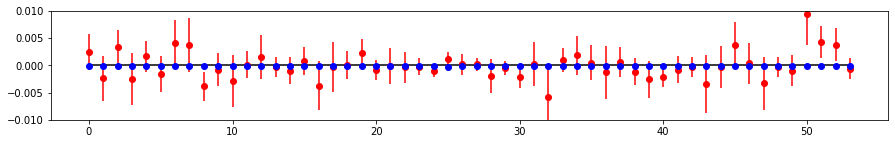

tensor(2.533488276958e-03, dtype=torch.float64)
tensor(2.925553400033e-05, dtype=torch.float64)


In [56]:
##################################################
# improve measured phase (assuming model is ok) #
##################################################

# seems to introduce bias ??? but it is small
# bias is the same for all, can remove it?
# second pass??? doesn't help

# all are monitor
data_model = torch.clone(model)

out = []

# loop over each monitor
for i in range(len(data_model)):
    data_index = [i]
    data_local = [i for i in range(len(data_model)) if i not in data_index]
    data_phase = torch.stack([phase for i, phase in enumerate(out3) if i not in data_index])
    data_error = torch.stack([error for i, error in enumerate(err3) if i not in data_index])
    result = virtual_phase(i, frequency, data_model, data_local, data_phase, data_error) ;
    out.append(result['fit'])

out = torch.tensor(numpy.array(out).T)

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out[0] - phase).cpu().numpy(), yerr=out[1], fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()
print((out3 - phase).std())
print((out[0] - phase).std())

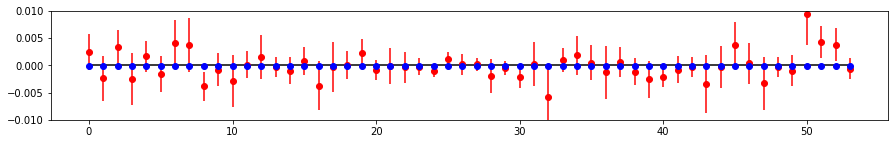

tensor(5.607143205793e-07, dtype=torch.float64)


In [57]:
# second pass 
# seems to be better for several, can use errors from first and do several loops
# only one loop has some effect

new = torch.clone(out) 
out = []

# all are monitor
data_model = torch.clone(model)

# loop over each monitor
for i in range(len(data_model)):
    data_index = [i]
    data_local = [i for i in range(len(data_model)) if i not in data_index]
    data_phase = torch.stack([phase for i, phase in enumerate(new[0]) if i not in data_index])
    data_error = torch.stack([error for i, error in enumerate(new[1]) if i not in data_index])
    result = virtual_phase(i, frequency, data_model, data_local, data_phase, data_error) ;
    out.append(result['fit'])

out = torch.tensor(numpy.array(out).T)

plt.figure(figsize=(15, 2))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out[0] - phase).cpu().numpy(), yerr=out[1], fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()
print((out[0] - phase).std())

In [58]:
generate_pairs(2, 2)

[[2, [[0, -1], [0, 1]]],
 [3, [[0, -2], [0, -1]]],
 [3, [[0, -2], [0, 1]]],
 [3, [[0, -1], [0, 2]]],
 [3, [[0, 1], [0, 2]]],
 [4, [[0, -2], [0, 2]]]]

In [59]:


# generate local (ids of monitor in data_model)


# generate phase (exclude data_index)


# generate error (exclude data_index)


In [60]:
## ADD 'CENTER' ?
## USE NEGATIVE TURN ?
## DISTANCE WEIGHT ?

[0, 1, 5, 10, 15]
[-5.528600668625039e-05, 0.0025448486795797156]
[0.0001321610460984779, 0.00023589904600809008]
[-0.0008465429053232665, 0.002554866476592463]


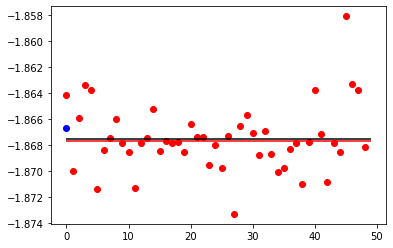

In [61]:
# DBSCAN, epsilon based on n*std

# model advance for all locations (monitor & virtual)
data_model = torch.clone(model)

# define indices of virtial
data_index = [0, 1, 5, 10, 15]

# generate local (ids of monitor in data_model)
data_local = [i for i in range(len(data_model)) if i not in data_index]

# generate phase (exclude data_index)
data_phase = torch.stack([phase for i, phase in enumerate(out3) if i not in data_index])

# generate error (exclude data_index)
data_error = torch.stack([error for i, error in enumerate(err3) if i not in data_index])


def virtual_phase(index:int, frequency:float, model:torch.Tensor,
                  local:list, phase:torch.Tensor, error:torch.Tensor=None,
                  fit:bool=True) -> dict:
    """
    
    index      -- location index in a list with model data (model data for all locations)
    frequency  -- measured (fractional) frequency
    model      -- model data for all locations (advance from zero to location)
    local      -- list of monitor indices as appear in model data
    phase      -- list of monitor measured phases
    error      -- errors for measured phases
    fit        -- flag to fit data
    
    
    """
    
    result = {}
    
    size = len(model)
    
    table = []
    sigma = []
    
    for i, monitor in enumerate(local):
        advance, _ = Decomposition.phase_advance(index, monitor, frequency, model)
        virtual = mod(phase[i] - advance, 2.0*numpy.pi, -numpy.pi)
        table.append(virtual)
        if error != None:
            sigma.append(error[i])
    
    table = torch.stack(table)
    if error != None:
        sigma = torch.stack(sigma)

    result['fit'] = None
    result['table'] = table.cpu().numpy()
    result['sigma'] = None if error == None else sigma.cpu().numpy()
    
    # outliers
#     from sklearn.cluster import DBSCAN
#     from collections import Counter
#     epsilon = 3.0*result['table'].std()
#     group = DBSCAN(eps=epsilon).fit(result['table'].reshape(-1, 1))
#     label, *_ = Counter(group.labels_)
#     print(group.labels_)
#     result['table'] = result['table'][group.labels_ == label]
#     result['sigma'] = None if error == None else result['sigma'][group.labels_ == label]
    
    if fit:
        from statsmodels.api import WLS
        x = numpy.ones((len(result['table']), 1))
        y = result['table']
        w = x if error == None else (1/result['sigma']**2)
        fit = WLS(y, x, w).fit()
        result['fit'] = [fit.params.item(), fit.bse.item()]
    
    return result

print(data_index)
i = 15
result = virtual_phase(i, frequency, data_model, data_local, data_phase, data_error) 
print([phase[i].item()-result['table'].mean().item(), result['table'].std().item()])
print([phase[i].item()-result['fit'][0], result['fit'][1]])
print([phase[i].item()-out3[i].item(), err3[i].item()])

plt.scatter(range(len(result['table'])), result['table'], color='red')
plt.scatter(0, out3[i].item(), color='blue')
plt.hlines(phase[i].item(), 0, len(result['table']), color='black')
plt.hlines(result['fit'][0], 0, len(result['table']), color='red')
plt.show()

In [62]:
# TODO
# 1. do by range with option to keep only on 1 turn
# 2. dbsan cleaning before fit
# 3. add model errors (compute sigma for model error)
# 4. inclide frequency error

# derived functions (where to fit?)
# 1. return phases and errors (with cleaning?)
# 2. function for virtual
# 3. function for accuracy can do second loop (need to include original, so fit after?)
#    use function for virtual without fit, fit after, opionaly second pass

In [63]:
# data preparation

# model advance & error for all locations (monitor & virtual)
# error is between locations (from given location to the next location)
MODEL = torch.clone(model)
MODEL_ERROR = 1.0E-3*torch.ones_like(MODEL)

# measured phase & error for all locations (monitor & virtual)
# phase at locations of monitors is computed from signals, for virtual locations phase is not used, can be zero initialy
PHASE = torch.clone(out3)
PHASE_ERROR = torch.clone(err3)

# here all locations are monitors, set subset to virtual
INDEX = [0, 1, 5, 10, 15]

# flags
# 1/0  -monitor/virtual
FLAGS = torch.ones_like(MODEL, dtype=torch.int32)
# FLAGS[INDEX] = 0

In [64]:
# TO DO
# CHANGE ADVANCE TO COMPUTE ERROR INSIDE
# PASS FREQUENCY, NOT ADVANCE ON INPUT
# ERRORS
# DBSCAN
# FIT

[-3.814072371399746e-05, 0.0025162609519300823]
[0.00011888045403884995, 0.00016014832719954647]
[0.002776594539471766, 0.004782138036109702]


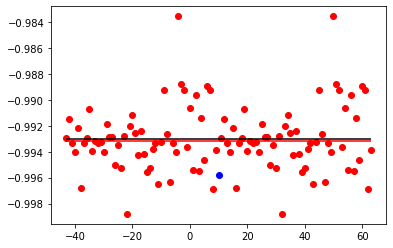

In [69]:
def phase_virtual(probe:int,
                  limit:int,
                  flags:torch.Tensor, 
                  q:torch.Tensor,
                  Q:torch.Tensor,
                  phase:torch.Tensor,
                  PHASE:torch.Tensor,
                  *,
                  full:bool=True,
                  clean:bool=True,
                  factor:float=5.0,
                  fit:bool=True,
                  error:bool=True,
                  sigma_q:torch.Tensor=None, 
                  sigma_Q:torch.Tensor=None, 
                  sigma_phase:torch.Tensor=None,
                  sigma_PHASE:torch.Tensor=None) -> dict:
    """
    Estimate phase at virtual or monitor location using other monitor locations and model phase data.
        
    Note, sigma_phase contains error for measured phase, only errors for monitors are used
    Note, sigma_PHASE contains error from given location to the next location, should be defined for all locations

    Parameters
    ----------
    probe: int
        location index
    limit: int
        range limit around probe location
    flags: torch.Tensor
        virtual/monitor flags 0/1 for each location
    q: float
        measured tune (fractional part)
    Q: float
        model tune
    phase: torch.Tensor
        measured phase data
    PHASE: torch.Tensor
        model phase data
    full: bool
        flag to use locations on different turns
    clean: bool
        flag to clean data using DBSCAN
    factor: float
        epsilon = factor*data.std()
    fit: bool
        flag to fit data
    error:
        flag to compute errors
    sigma_q: torch.Tensor
        measured tune error
    sigma_Q: torch.Tensor
        model tune error
    sigma_phase: torch.Tensor
        measured phase error
    sigma_PHASE: torch.Tensor
        model phase error

    Returns
    -------
    vrtual phase dict

    """
    
    # REMOVE
    cls = Decomposition
    
    result = {}
    
    count = len(model)
    
    limit = min(limit, count - 1)
    
    index = {}
    for i in (i + probe for i in range(-limit, 1 + limit) if i != 0):
        if flags[int(mod(i, count))] == 1:
            index[i] = int(mod(i, count))
    
    if not full:
        index = {key: value for key, value in index.items() if key > 0 and key < count} 
    
    table = []
    error = []
    for i in index:
        correct, correct_error = cls.phase_adjust(i, q, phase, sigma_q, sigma_phase)
        advance, advance_error = cls.phase_advance(probe, i, Q, PHASE, True, sigma_Q, sigma_PHASE)
        virtual, virtual_error = mod(correct - advance, 2.0*numpy.pi, -numpy.pi), (correct_error**2 + advance_error**2)**0.5
        table.append(virtual)
        error.append(virtual_error)
        
    table = torch.stack(table)
    error = torch.stack(error)

    result['model'] = None
    result['probe'] = probe
    result['limit'] = limit
    result['index'] = index
    result['clean'] = None
    result['phase'] = table
    result['error'] = error
        
    if clean:
        from sklearn.cluster import DBSCAN
        from collections import Counter
        epsilon = factor*table.std().cpu().numpy()
        cluster = DBSCAN(eps=epsilon).fit(table.cpu().numpy().reshape(-1, 1))
        primary, *_ = Counter(cluster.labels_)
        clean = {key: index[key] for key, cluster in zip(index, cluster.labels_) if cluster != primary}
        index = {key: index[key] for key, cluster in zip(index, cluster.labels_) if cluster == primary}
        result['index'] = index
        result['clean'] = clean
        result['phase'] = table[cluster.labels_ == primary]
        result['error'] = error[cluster.labels_ == primary]

    if fit:
        from statsmodels.api import WLS
        x = numpy.ones((len(result['phase']), 1))
        y = result['phase'].cpu().numpy()
        s = result['error'].cpu().numpy()
        w = x if error == None else (1/s**2)
        fit = WLS(y, x, w).fit()
        result['model'] = [fit.params.item(), fit.bse.item()]
    
    return result
    

I = 10
LIMIT = 60
FREQUENCY = frequency
FREQUENCY_ERROR = spread
result = phase_virtual(I, LIMIT, FLAGS, FREQUENCY, total/(2.0*numpy.pi), PHASE, MODEL, sigma_q=1.0E-9, sigma_phase=PHASE_ERROR)

print([phase[I].item()-result['phase'].mean().item(), result['phase'].std().item()])
print([phase[I].item()-result['model'][0], result['model'][1]])
print([phase[I].item()-out3[I].item(), err3[I].item()])

plt.scatter(list(result['index']), result['phase'], color='red')
plt.scatter(I, out3[I].item(), color='blue')
plt.hlines(phase[I].item(), min(result['index'].keys()), max(result['index'].keys()), color='black')
plt.hlines(result['model'][0], min(result['index'].keys()), max(result['index'].keys()), color='red')
plt.show()

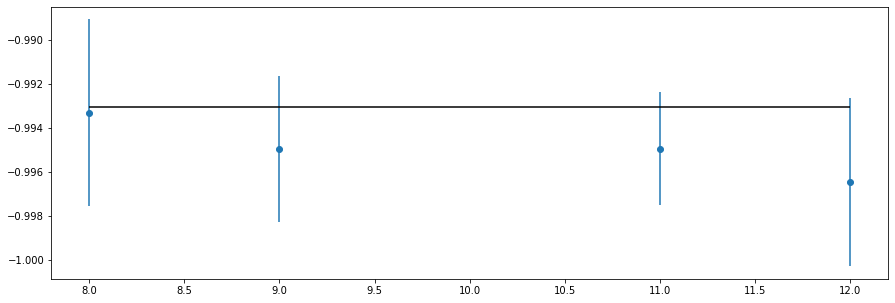

In [95]:
# FOR LARGE RANGE DATA IS REDYNDENT (PERIODIC)
# CAN SELF PICK??? 
# self-turn, self, self+turn max data that make sence
# can pass any limit, but trim? DONE

# frequency error is very small, since max by +-1 turn shift
plt.figure(figsize=(15, 5))
plt.errorbar([*result['index'].keys()], result['table'].cpu().numpy(), yerr=result['error'].cpu().numpy(), fmt='o')
plt.hlines(phase[I].item(), min(result['index']), max(result['index']), color='black')
plt.show()

In [ ]:
# new loop
# old loop + correction + virtual

In [228]:
# seems to work, but be careful with PHASE and phase, ERROR and error
# should be ok, used wrong array length
# remember to remove start/end

[1, 27, 53]


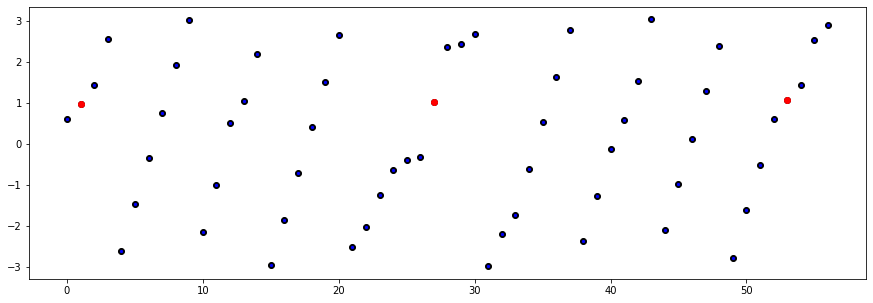

In [96]:
def phase_virtual(probe:int,
                  limit:int,
                  flags:torch.Tensor, 
                  q:torch.Tensor,
                  Q:torch.Tensor,
                  phase:torch.Tensor,
                  PHASE:torch.Tensor,
                  *,
                  full:bool=True,
                  clean:bool=True,
                  factor:float=5.0,
                  fit:bool=True,
                  error:bool=True,
                  sigma_q:torch.Tensor=None, 
                  sigma_Q:torch.Tensor=None, 
                  sigma_phase:torch.Tensor=None,
                  sigma_PHASE:torch.Tensor=None) -> dict:
    """
    Estimate phase at virtual or monitor location using other monitor locations and model phase data.
        
    Note, sigma_phase contains error for measured phase, only errors for monitors are used
    Note, sigma_PHASE contains error from given location to the next location, should be defined for all locations

    Parameters
    ----------
    probe: int
        location index
    limit: int
        range limit around probe location
    flags: torch.Tensor
        virtual/monitor flags 0/1 for each location
    q: float
        measured tune (fractional part)
    Q: float
        model tune
    phase: torch.Tensor
        measured phase data
    PHASE: torch.Tensor
        model phase data
    full: bool
        flag to use locations on different turns
    clean: bool
        flag to clean data using DBSCAN
    factor: float
        epsilon = factor*data.std()
    fit: bool
        flag to fit data
    error:
        flag to compute errors
    sigma_q: torch.Tensor
        measured tune error
    sigma_Q: torch.Tensor
        model tune error
    sigma_phase: torch.Tensor
        measured phase error
    sigma_PHASE: torch.Tensor
        model phase error

    Returns
    -------
    vrtual phase dict

    """
    
    # REMOVE
    cls = Decomposition
    
    result = {}
    
    count = len(model)
    
    limit = min(limit, count - 1)
    
    index = {}
    for i in (i + probe for i in range(-limit, 1 + limit) if i != 0):
        if flags[int(mod(i, count))] == 1:
            index[i] = int(mod(i, count))
    
    if not full:
        index = {key: value for key, value in index.items() if key > 0 and key < count} 
    
    table = []
    error = []
    for i in index:
        correct, correct_error = cls.phase_adjust(i, q, phase, sigma_q, sigma_phase)
        advance, advance_error = cls.phase_advance(probe, i, Q, PHASE, True, sigma_Q, sigma_PHASE)
        virtual, virtual_error = mod(correct - advance, 2.0*numpy.pi, -numpy.pi), (correct_error**2 + advance_error**2)**0.5
        table.append(virtual)
        error.append(virtual_error)
        
    table = torch.stack(table)
    error = torch.stack(error)

    result['model'] = None
    result['probe'] = probe
    result['limit'] = limit
    result['index'] = index
    result['clean'] = None
    result['phase'] = table
    result['error'] = error
        
    if clean:
        from sklearn.cluster import DBSCAN
        from collections import Counter
        epsilon = factor*table.std().cpu().numpy()
        cluster = DBSCAN(eps=epsilon).fit(table.cpu().numpy().reshape(-1, 1))
        primary, *_ = Counter(cluster.labels_)
        clean = {key: index[key] for key, cluster in zip(index, cluster.labels_) if cluster != primary}
        index = {key: index[key] for key, cluster in zip(index, cluster.labels_) if cluster == primary}
        result['index'] = index
        result['clean'] = clean
        result['phase'] = table[cluster.labels_ == primary]
        result['error'] = error[cluster.labels_ == primary]

    if fit:
        from statsmodels.api import WLS
        x = numpy.ones((len(result['phase']), 1))
        y = result['phase'].cpu().numpy()
        s = result['error'].cpu().numpy()
        w = x if error == None else (1/s**2)
        fit = WLS(y, x, w).fit()
        result['model'] = [fit.params.item(), fit.bse.item()]
    
    return result


# COMPUTE AT VIRTUAL COLACTIONS (DROP START/END)

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['S'])}
    
model = torch.tensor([value['FX'] for key, value in config.items() if key not in ['START', 'END']], dtype=torch.float64)
error = 1.0E-4*torch.ones_like(model)

index = {key: value for key, value in config.items() if key not in ['START', 'END']}
index = [index for index, (key, value) in enumerate(index.items()) if value['TYPE'] == 'MONITOR']

data_model = torch.clone(model)
data_index = [i for i in range(len(data_model)) if i not in index]

MODEL = torch.clone(model)
MODEL_ERROR = error

PHASE = 0.0*torch.clone(model)
PHASE_ERROR = 0.0*torch.clone(model)
PHASE[index] = out3
PHASE_ERROR[index] = err3

FLAGS = torch.ones_like(MODEL, dtype=torch.int32)
FLAGS[data_index] = 0

print(data_index)

out = []
err = []

LIMIT = len(MODEL)
q = frequency
sigma_q = spread

Q = total/(2.0*numpy.pi)
sigma_Q = torch.sum(MODEL_ERROR**2).sqrt()

for I in range(len(MODEL)):
    result = phase_virtual(I, LIMIT, FLAGS, q, Q, PHASE, MODEL, sigma_q=sigma_q, sigma_Q=sigma_Q, sigma_phase=PHASE_ERROR, sigma_PHASE=MODEL_ERROR)
    out.append(result['phase'].mean())
    err.append(result['error'].mean())
    
out = torch.stack(out)
plt.figure(figsize=(15, 5))
# plt.errorbar(range(len(out)), out, yerr=err, color='black', fmt=' ', marker='o')
plt.scatter(range(len(out)), out, color='black')
plt.scatter(data_index, out[data_index].cpu().numpy(), color='red')
plt.scatter(index, phase, color='blue', s=5)
plt.show()